In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot
include("/home/postdoc/dsen/Desktop/G-ZZ/jl_files/zz_samplers.jl")
include("temp.jl")

run_sampler (generic function with 3 methods)

#### Simulate data:

In [2]:
n_groups, group_size = 30, 100
Nobs = group_size*n_groups
d = 5
dim_total = 1+n_groups+d

σ02 = 1
my_pr = MM_prior(d, n_groups, σ02);

In [3]:
pX = 5e-2
X = spzeros(dim_total, Nobs)
X[1,:] = 1
for group in 1:n_groups
    X[group+1,((group-1)*group_size+1):(group*group_size)] = 1
end
X[n_groups+2:end,:] = sprandn(d, Nobs, pX)
ξ_true = rand(Normal(),dim_total)
y = Float64.([rand(Binomial(1, 1/(1+exp(-ξ_true'X[:,j])))) for j in 1:Nobs])
my_ll = ll_logistic_sp(X,y)
my_model = model(my_ll, my_pr);

#### Run sampler:

In [4]:
mb_size = 1
max_attempts = 10^7
prob_het = 0.99
adapt_speed = "none"

lambda = 1e2
start = time()
Print = true
run_sampler(my_model, lambda, max_attempts, mb_size, Print, prob_het, adapt_speed)
print("Time = ", round((time()-start)/60,1), " mins")

10 percent attempts in 2.31 min; zz bounces = 105768, hyp bounces = 6218, total time of process = 63.018 
20 percent attempts in 4.78 min; zz bounces = 211130, hyp bounces = 12347, total time of process = 125.931 
30 percent attempts in 7.37 min; zz bounces = 316597, hyp bounces = 18659, total time of process = 188.819 
40 percent attempts in 10.05 min; zz bounces = 421982, hyp bounces = 24919, total time of process = 251.685 
50 percent attempts in 12.80 min; zz bounces = 527139, hyp bounces = 31209, total time of process = 314.588 
60 percent attempts in 15.60 min; zz bounces = 632562, hyp bounces = 37597, total time of process = 377.391 
70 percent attempts in 18.41 min; zz bounces = 738047, hyp bounces = 43972, total time of process = 440.220 
80 percent attempts in 21.25 min; zz bounces = 842744, hyp bounces = 50414, total time of process = 503.040 
90 percent attempts in 24.12 min; zz bounces = 947767, hyp bounces = 56547, total time of process = 565.854 
100 percent attempts in 

### Plot ACFs:

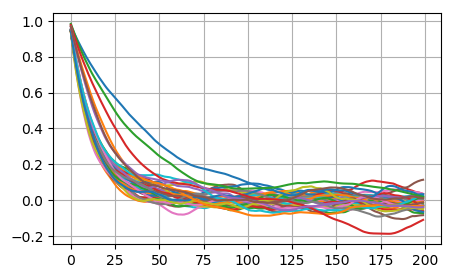

In [19]:
fig = figure("pyplot_barplot",figsize=(5,3))
n_samples = 10^4
maxlag_gzz = 200
acfs_gzz = zeros(dim_total,maxlag_gzz)
discard = 0
filename = "/xtmp/GZZ_data/mixed_effects/lambda:"*string(lambda)*
        "-dim_cov:"*string(d)*"-n_groups:"*string(n_groups)*
        "-Nobs:"*string(Nobs)*"-mb_size:"*string(mb_size)*".jld"
xt_skel, bt_skel = load(filename, "xt_skeleton", "bt_skeleton")
xi_samples_gzz = extract_samples(xt_skel[:,discard+1:end], 
                                 bt_skel[:,discard+1:end], 
                                 (bt_skel[end]-bt_skel[discard+1])/n_samples,
                                 "linear")[:,1:end-1]
for dim in 1:size(xi_samples_gzz,1)
    a = acf(xi_samples_gzz[dim,:],maxlag_gzz)
    plot(a)
    acfs_gzz[dim,:] = a
end
grid(true)
xt_skel, bt_skel, xi_samples = [], [], []
gc()

### Tune HMC:

In [6]:
ξ0 = randn(dim_total)
Total_time = 5
T = 250
Metropolise = false
Print = false
n_leapfrog_list = 25*(1:5)

25:25:125

In [7]:
for (i,n_leapfrog) in enumerate(reverse(n_leapfrog_list))
    start = time()
    prior = MM_prior(d, n_groups, σ02)
    my_ll = ll_logistic_sp(X,y)
    my_model = model(my_ll, prior)
    stepsize = Total_time/n_leapfrog
    xi_samples, hyper_samples, acc = 
    GibbsHMC(my_model, ξ0, stepsize, n_leapfrog, T, Metropolise, Print)
    print("n_leapfrog = ", n_leapfrog, " in ", round((time()-start)/60,2), " mins \n")
end

HMC acceptance = 100.0 percent; n_leapfrog = 125 in 1.3 mins 
HMC acceptance = 100.0 percent; n_leapfrog = 100 in 1.03 mins 


LoadError: [91mArgumentError: Gamma: the condition α > zero(α) && θ > zero(θ) is not satisfied.[39m

In [8]:
Metropolise = true 
Print = false

stepsize = Total_time/90
total_times = 6*stepsize*(6:15)
n_leapfrog_steps = 5*(4:10)

for total_time in total_times
    print("Total time = ", round(total_time,2), "\n")
    for n_leapfrog in n_leapfrog_steps
        start = time()
        prior = MM_prior(d, n_groups, σ02)
        my_ll = ll_logistic_sp(X,y)
        my_model = model(my_ll, prior)
        a, b, c = 
        GibbsHMC(my_model, ξ0, total_time/n_leapfrog, n_leapfrog, 500, Metropolise, Print)
        print("n_leapfrog = ", n_leapfrog, " in ", round((time()-start)/60,2), " mins \n")
        if c > 0.7 
            break
        end
    end
end

Total time = 2.0
HMC acceptance = 0.4 percent; n_leapfrog = 20 in 0.43 mins 
HMC acceptance = 1.2 percent; n_leapfrog = 25 in 0.53 mins 
HMC acceptance = 73.4 percent; n_leapfrog = 30 in 0.63 mins 
Total time = 2.33
HMC acceptance = 0.0 percent; n_leapfrog = 20 in 0.42 mins 
HMC acceptance = 0.4 percent; n_leapfrog = 25 in 0.53 mins 
HMC acceptance = 2.4 percent; n_leapfrog = 30 in 0.64 mins 
HMC acceptance = 74.0 percent; n_leapfrog = 35 in 0.73 mins 
Total time = 2.67
HMC acceptance = 0.0 percent; n_leapfrog = 20 in 0.42 mins 
HMC acceptance = 0.0 percent; n_leapfrog = 25 in 0.52 mins 
HMC acceptance = 0.6 percent; n_leapfrog = 30 in 0.64 mins 
HMC acceptance = 1.6 percent; n_leapfrog = 35 in 0.74 mins 
HMC acceptance = 69.4 percent; n_leapfrog = 40 in 0.85 mins 
HMC acceptance = 83.0 percent; n_leapfrog = 45 in 0.93 mins 
Total time = 3.0
HMC acceptance = 0.0 percent; n_leapfrog = 20 in 0.41 mins 
HMC acceptance = 0.2 percent; n_leapfrog = 25 in 0.52 mins 
HMC acceptance = 0.2 perce

LoadError: [91mInterruptException:[39m

In [12]:
total_times_optimal = round.(total_times,2)
n_leapfrog_optimal =  [30,34,39,44,55,1,1,1,1,1];

In [13]:
T = 5000
Metropolise = true
Print = false

for (i,total_time) in enumerate(total_times_optimal) 
    n_leapfrog = n_leapfrog_optimal[i]
    start = time()
    prior = MM_prior(d, n_groups, σ02)
    my_ll = ll_logistic_sp(X,y)
    my_model = model(my_ll, prior)
    xi_samples_hmc, hyper_samples_hmc, acc =
    GibbsHMC(my_model, ξ0, total_time/n_leapfrog, n_leapfrog, T, Metropolise, Print)
    print("n_leapfrog = ", n_leapfrog, " in ", round((time()-start)/60,2), " mins \n")
    filename  = "/xtmp/GZZ_data/mixed_effects/GibbsHMC:d:"*
                string(d)*"-n_groups:"*string(n_groups)*"-Nobs:"*string(Nobs)*
                "-total_time:"*string(total_time)*"-n_leapfrog:"*string(n_leapfrog)*".jld"
    save(filename, "xi_samples", xi_samples_hmc, "hyper_samples", hyper_samples_hmc, "acc", acc)
    xi_samples_hmc, hyper_samples_hmc, acc = [], [], []
    gc()
end

HMC acceptance = 73.0 percent; n_leapfrog = 30 in 6.44 mins 
HMC acceptance = 58.84 percent; n_leapfrog = 34 in 7.23 mins 
HMC acceptance = 59.42 percent; n_leapfrog = 39 in 8.27 mins 
HMC acceptance = 63.68 percent; n_leapfrog = 44 in 9.23 mins 
HMC acceptance = 83.9 percent; n_leapfrog = 55 in 11.42 mins 
HMC acceptance = 0.0 percent; n_leapfrog = 1 in 0.45 mins 
HMC acceptance = 0.0 percent; n_leapfrog = 1 in 0.44 mins 
HMC acceptance = 0.0 percent; n_leapfrog = 1 in 0.44 mins 
HMC acceptance = 0.0 percent; n_leapfrog = 1 in 0.44 mins 
HMC acceptance = 0.0 percent; n_leapfrog = 1 in 0.44 mins 


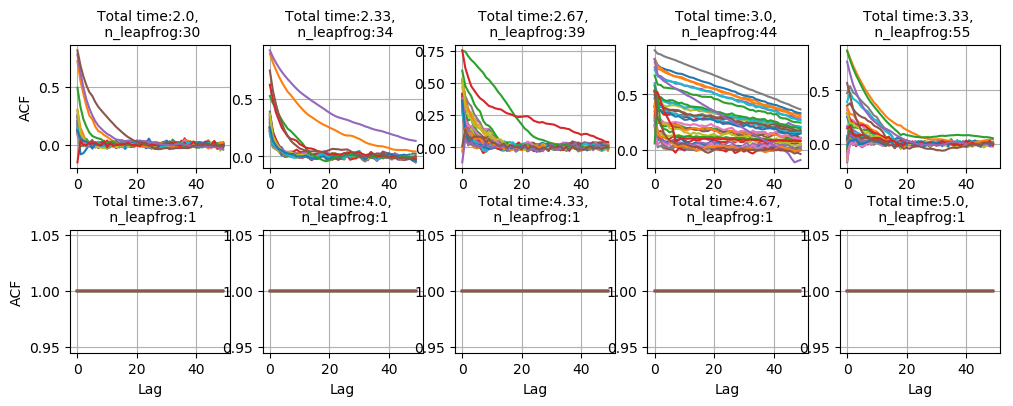

In [14]:
maxlag_hmc = 50
fig = figure(figsize=(12,4))
acfs_hmc = zeros(length(total_times_optimal),dim_total,maxlag_hmc)

for i in 1:2 
    for j in 1:5
        k = 5*(i-1)+j
        total_time, n_leapfrog = total_times_optimal[k], n_leapfrog_optimal[k]
        filename  = "/xtmp/GZZ_data/mixed_effects/GibbsHMC:d:"*
                string(d)*"-n_groups:"*string(n_groups)*"-Nobs:"*string(Nobs)*
                "-total_time:"*string(total_time)*"-n_leapfrog:"*string(n_leapfrog)*".jld"
        xi_samples_hmc = load(filename, "xi_samples")

        subplot(2,5,k)
        for dim in 1:size(xi_samples_hmc,1) 
            a = acf(xi_samples_hmc[dim,:], maxlag_hmc)
            plot(a)
            acfs_hmc[k,dim,:] = a
        end
        grid(true)  
        title("Total time:"*string(total_time)*", \n n_leapfrog:"*string(n_leapfrog), fontsize=10)
        xi_samples_hmc = []
        gc()
        if i == 2 xlabel("Lag") end
        if j == 1 ylabel("ACF") end
        subplots_adjust(hspace=0.5)
    end
end

In [15]:
T = 5000
maxlag_hmc_list = [25, 50, 40, 50, 50, 50, 50, 50, 25, 25]
hmc_mixing = zeros(length(total_times_optimal))
for i in 1:length(total_times_optimal)
    hmc_mixing[i] = T/maximum(sum(acfs_hmc[i,:,1:maxlag_hmc_list[i]],2))
end
hmc_cost = T*n_leapfrog_optimal*Nobs;

In [20]:
gzz_mixing = n_samples/maximum(sum(acfs_gzz[:,1:125],2))
gzz_cost = max_attempts*mb_size
minimum((gzz_mixing/gzz_cost)./(hmc_mixing./hmc_cost))

NaN

In [21]:
(gzz_mixing/gzz_cost)./(hmc_mixing./hmc_cost)

10-element Array{Float64,1}:
  13.3119
  48.5219
  31.553 
 100.66  
  39.6013
 NaN     
 NaN     
 NaN     
 NaN     
 NaN     

In [43]:
k=5
total_time, n_leapfrog = total_times_optimal[k], n_leapfrog_optimal[k]
filename  = "/xtmp/GZZ_data/mixed_effects/GibbsHMC:d:"*
        string(d)*"-n_groups:"*string(n_groups)*"-Nobs:"*string(Nobs)*
        "-total_time:"*string(total_time)*"-n_leapfrog:"*string(n_leapfrog)*".jld"
xi_samples_hmc, hyper_samples_hmc = load(filename, "xi_samples", "hyper_samples");

In [44]:
size(xi_samples_hmc)

(16, 5001)

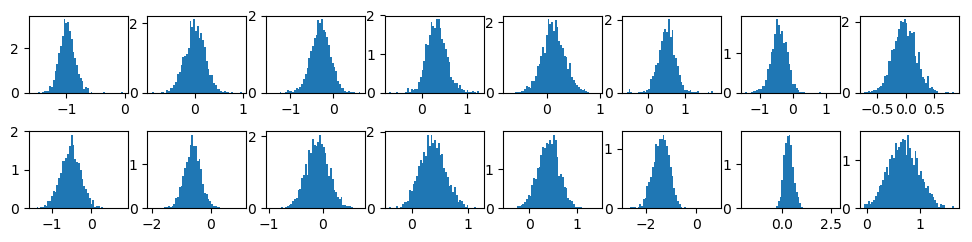

In [48]:
fig = figure(figsize=(12,2.5))
for i in 1:8
    for j in 1:2
        k = (j-1)*8+i
        subplot(2,8,k)
        hist(xi_samples_hmc[k,:], density=true, bins=50)
#         grid(true)
    end
end
subplots_adjust(hspace=0.5)

In [49]:
mean(xi_samples_hmc,2)

16×1 Array{Float64,2}:
 -0.984705  
  0.00396715
 -0.298673  
  0.333913  
  0.124698  
  0.506394  
 -0.415683  
 -0.02293   
 -0.522084  
 -0.620767  
 -0.0989715 
  0.375533  
  0.408167  
 -1.38292   
  0.353295  
  0.695113  

In [51]:
std(xi_samples_hmc,2)

16×1 Array{Float64,2}:
 0.135768
 0.209415
 0.231017
 0.228953
 0.212504
 0.24536 
 0.243652
 0.205863
 0.259145
 0.292029
 0.212147
 0.226505
 0.228325
 0.325404
 0.246505
 0.286129